### VaR Comparison

##### Imports & Config

In [156]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import seaborn as sns


In [157]:
import warnings
warnings.filterwarnings("ignore")

#### Fetching stock data

In [158]:
stock_df = pd.read_csv('data/stock_data.csv')

In [159]:
stock_df['Date'] = pd.to_datetime(stock_df['Date'], utc=True)
stock_df['Date'] = stock_df['Date'].dt.date
stock_df['Date'] = stock_df['Date'].apply(lambda x: dt.datetime.combine(x, dt.time(0, 0)))

In [160]:
def convert_csv_df_to_yf_df(csv_df):
    """Convert a CSV DataFrame to a format similar to Yahoo Finance DataFrame.
    The CSV DataFrame should have 'Date', 'Ticker', 'Open', 'High', 'Low', 'Close', and 'Volume' columns.
    """    

    # Ensure the Date column is of datetime type.
    csv_df['Date'] = pd.to_datetime(csv_df['Date'])

    # Define the price columns that you want to keep.
    price_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

    # Pivot the DataFrame.
    # With a list for values, pivot_table creates a MultiIndex on the columns where the first level is the price fields
    # and the second level is the ticker symbol.
    multi_df = csv_df.pivot_table(index='Date', columns='Ticker', values=price_cols)

    # Optionally, sort the MultiIndex columns.
    multi_df = multi_df.sort_index(axis=1)

    # Set the MultiIndex column names so that the first level is 'Price' and the second is 'Ticker'.
    multi_df.columns.names = ['Price', 'Ticker']

    return multi_df


#### Declaring classes

##### Portofolio Class

In [161]:

class PortofolioData:
    def __init__(self, stocks, weights, Time, initial_investment, forecast_start_date=dt.datetime.now(), yahoo_finance=False):
        self.stocks = stocks
        self.weights = np.array(weights)
        self.Time = Time  # number of days over which the var is calculated
        self.initial_investment = initial_investment
        self.forecast_start_date = forecast_start_date
        self.yahoo_finance = yahoo_finance
        self.returns, self.mean_returns, self.cov_matrix = self.get_data(
                start_date=forecast_start_date-dt.timedelta(days=800), end_date=forecast_start_date, yahoo_finance=yahoo_finance)

    def get_data(
        self,
        start_date=dt.datetime.now() - dt.timedelta(days=800),
        end_date=dt.datetime.now(),
        yahoo_finance=False,
    ):
        # Get historical data and calculate returns
        if yahoo_finance:
            stock_data = yf.download(self.stocks, start=start_date, end=end_date)
        else:
            stock_data = stock_df[(stock_df['Ticker'].isin(self.stocks)) & (stock_df['Date'] >= start_date) & (stock_df['Date'] < end_date)]
            stock_data = convert_csv_df_to_yf_df(stock_data)
        stock_data = stock_data["Close"]
        returns = stock_data.pct_change()
        mean_returns = returns.mean()
        cov_matrix = returns.cov()
        returns = returns.dropna()
        returns["portofolio"] = returns.dot(self.weights)

        if stock_data.empty:
            raise ValueError("No data found for the selected date range and tickers.")


        return returns, mean_returns, cov_matrix

    def get_expected_portofolio_performance(self):
        expected_returns = np.sum(self.mean_returns * self.weights) * self.Time
        expected_std = np.sqrt(
            np.dot(self.weights.T, np.dot(self.cov_matrix, self.weights))
        ) * np.sqrt(self.Time)
        return expected_returns, expected_std

    def __str__(self):
        txt = ""
        txt += f"PORTOFOLIO: {self.initial_investment}\n"
        for i in range(len(self.stocks)):
            txt += f"{self.stocks[i]}:{self.weights[i]*100}%\n"
        txt += "--------------------------\n"
        txt += "Returns:\n"
        txt += f"{self.returns}\n"
        txt += "--------------------------\n"
        txt += "Mean Returns:\n"
        txt += f"{self.mean_returns}\n"
        txt += "--------------------------\n"
        txt += "Covariance Matrix\n"
        txt += f"{self.cov_matrix}\n"
        txt += "--------------------------\n"
        return txt


##### VaR Class

In [261]:
class VaR:
    def __init__(self, portofolio: PortofolioData, confidence_level=0.95):
        self.portofolio = portofolio
        self.confidence_level = confidence_level
        self.alpha = 1 - confidence_level

    def calculate_historical_var(self):
        h_var = -np.percentile(
            self.portofolio.returns["portofolio"], self.alpha * 100
        ) * np.sqrt(self.portofolio.Time)

        return {
            "relative": h_var,
            "absolute": self.portofolio.initial_investment * h_var,
        }

    def calculate_parametric_var(self):

        expected_portofolio_return, expected_portofolio_std = (
            self.portofolio.get_expected_portofolio_performance()
        )

        p_var = (
            norm.ppf(self.confidence_level) * expected_portofolio_std
            - expected_portofolio_return
        )

        return {
            "relative": p_var,
            "absolute": self.portofolio.initial_investment * p_var,
        }

    def calculate_monte_carlo_var(self, simulations=1000):
        mean_m = np.full(
            shape=(self.portofolio.Time, len(self.portofolio.weights)),
            fill_value=self.portofolio.mean_returns,
        )
        mean_m = mean_m.T

        portfolio_sims = np.full(
            shape=(self.portofolio.Time, simulations), fill_value=0.0
        )

        for m in range(0, simulations):
            Z = np.random.normal(
                size=(self.portofolio.Time, len(self.portofolio.weights))
            )
            L = np.linalg.cholesky(self.portofolio.cov_matrix)
            daily_returns = mean_m + np.inner(L, Z)
            portfolio_sims[:, m] = (
                np.cumprod(np.inner(self.portofolio.weights, daily_returns.T) + 1)
                * self.portofolio.initial_investment
            )

        portResults = pd.Series(portfolio_sims[-1, :])
        kept = np.percentile(portResults, self.alpha * 100)

        absolute_mc_var = self.portofolio.initial_investment - kept
        relative_mc_var = absolute_mc_var / self.portofolio.initial_investment

        return {
            "relative": relative_mc_var,
            "absolute": absolute_mc_var,
        }
    
    def calculate_all_vars(self, version='relative', multiplier=1):
        historical_var = self.calculate_historical_var()
        parametric_var = self.calculate_parametric_var()
        monte_carlo_var = self.calculate_monte_carlo_var()

        return {
            "historical": multiplier*historical_var[version],
            "parametric": multiplier*parametric_var[version],
            "monte_carlo": multiplier*monte_carlo_var[version],
        }

    def __str__(self):
        historical_var = self.calculate_historical_var()
        parametric_var = self.calculate_parametric_var()
        monte_carlo_var = self.calculate_monte_carlo_var()

        txt = "Value at Risk (VaR) Analysis:\n"
        txt += f"Confidence Level: {self.confidence_level * 100}%\n"
        txt += f"Historical VaR: {historical_var}\n"
        txt += f"Parametric VaR: {parametric_var}\n"
        txt += f"Monte Carlo VaR: {monte_carlo_var}\n"
        return txt

##### Fetching test portofolios

In [163]:
from generate_random_portfolios import read_portfolios_from_json

test_portfolios = read_portfolios_from_json("data/random_portfolios.json")

In [164]:
tp = test_portfolios[1]
stocks = tp["stocks_list"]
weights = tp["stocks_weights"]
initial_investment = tp['initial_investment']
end_date = dt.datetime.strptime(tp["start_date"], "%Y-%m-%d")
start_date = end_date - dt.timedelta(days=800)


stock_data = stock_df[(stock_df['Ticker'].isin(stocks)) & (stock_df['Date'] >= start_date) & (stock_df['Date'] <= end_date)]
stock_data = convert_csv_df_to_yf_df(stock_data)

In [165]:
stock_data.head()

Price           Close                                        High             \
Ticker            AEO         CL        NVDA     POAHY        AEO         CL   
Date                                                                           
2021-07-14  34.434380  78.833656  198.099930  9.855833  35.522579  78.975727   
2021-07-15  32.541859  79.212524  189.361374  9.685287  34.254589  79.345129   
2021-07-16  31.756464  79.932388  181.321640  9.541668  33.062299  80.036579   
2021-07-19  31.652374  79.534569  187.499298  9.335216  32.532396  80.472273   
2021-07-20  32.731110  78.744179  185.824463  9.344192  32.910898  80.734444   

Price                                   Low                                   \
Ticker            NVDA     POAHY        AEO         CL        NVDA     POAHY   
Date                                                                           
2021-07-14  203.853292  9.945595  34.358681  77.933833  197.213842  9.819928   
2021-07-15  198.154885  9.748119  31.860551  78.284294  188.285585  9.631429   
2021-07-16  191.265832  9.703239  31.652375  79.240952  180.443032  9.523715   
2021-07-19  190.117631  9.335216  30.592565  78.786297  178.371314  9.173645   
2021-07-20  188.080884  9.451905  31.377959  78.725129  181.351581  9.245454   

Price            Open                                      Volume             \
Ticker            AEO         CL        NVDA     POAHY        AEO         CL   
Date                                                                           
2021-07-14  34.803420  78.265344  203.254238  9.927643  3509500.0  2959200.0   
2021-07-15  34.235664  78.928375  197.802936  9.703239  7619900.0  4200800.0   
2021-07-16  32.560783  79.240952  190.002826  9.676310  4933800.0  6527500.0   
2021-07-19  30.971066  79.922908  178.868021  9.245454  4767000.0  4960200.0   
2021-07-20  31.633449  79.820255  187.002597  9.308287  2529100.0  4884100.0   

Price                              
Ticker            NVDA      POAHY  
Date                               
2021-07-14  38010000.0   426700.0  
2021-07-15  55056400.0   403200.0  
2021-07-16  68822400.0   641000.0  
2021-07-19  74906000.0   563900.0  
2021-07-20  43468700.0  2572100.0

#### Comparing the VaR methods

##### Getting daily returns

In [166]:
# Get returns for each portofolio
returns = []
portofolios = []
cnt = 1
for test_portfolio in test_portfolios:
    test_portfolio["start_date"] = dt.datetime.strptime(test_portfolio["start_date"], "%Y-%m-%d")

    portofolio = PortofolioData(
        stocks=test_portfolio["stocks_list"],
        weights=test_portfolio["stocks_weights"],
        Time=test_portfolio["time"],
        initial_investment=test_portfolio["initial_investment"],
        forecast_start_date=  test_portfolio["start_date"],
        yahoo_finance=False,
    )
    portofolios.append(portofolio)

    ret, mean_ret, cov_matrix = portofolio.get_data(
        test_portfolio["start_date"], 
        test_portfolio["start_date"] + dt.timedelta(days=test_portfolio["time"])
    )

    returns.append(ret)


In [167]:

def show_portfolio_distribution(returns, quantile = 0.05):
    sns.histplot(returns, bins=30, kde=True)

    quantile_mark = returns.quantile(quantile)  
    plt.axvline(quantile_mark, color='red', linestyle='dashed', label=f'95% Quantile: {quantile_mark:.4f}')

    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.title('Portfolio Return Distribution')
    plt.legend()
    plt.show()

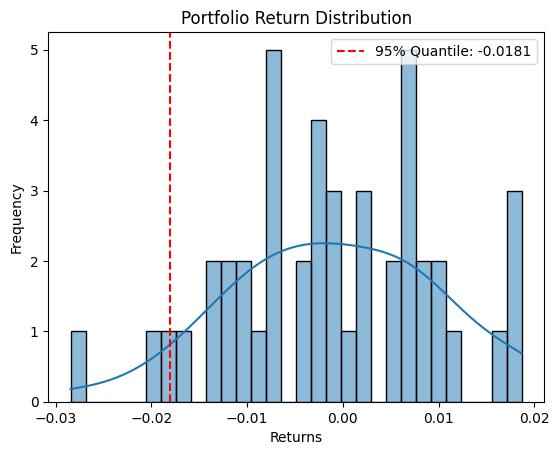

In [168]:
show_portfolio_distribution(returns[2]['portofolio'])

In [169]:
def compare_portfolio_distributions(forecast_returns, historic_returns, label1="Returns to Forecast", label2="Past historical Returns", quantile=0.05):
    plt.figure(figsize=(10, 6))
    
    # Plot both distributions
    sns.histplot(forecast_returns, bins=30, kde=True, color='blue', label=label1, stat="density", alpha=0.6)
    sns.histplot(historic_returns, bins=30, kde=True, color='orange', label=label2, stat="density", alpha=0.6)

    # Calculate quantiles
    q1 = forecast_returns.quantile(quantile)
    q2 = historic_returns.quantile(quantile)

    # Add vertical lines at quantiles
    plt.axvline(q1, color='blue', linestyle='dashed', label=f'{label1} {int(quantile*100)}% Quantile: {q1:.4f}')
    plt.axvline(q2, color='orange', linestyle='dashed', label=f'{label2} {int(quantile*100)}% Quantile: {q2:.4f}')
    
    plt.xlabel('Returns')
    plt.ylabel('Density')
    plt.title('Comparison of Portfolio Return Distributions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

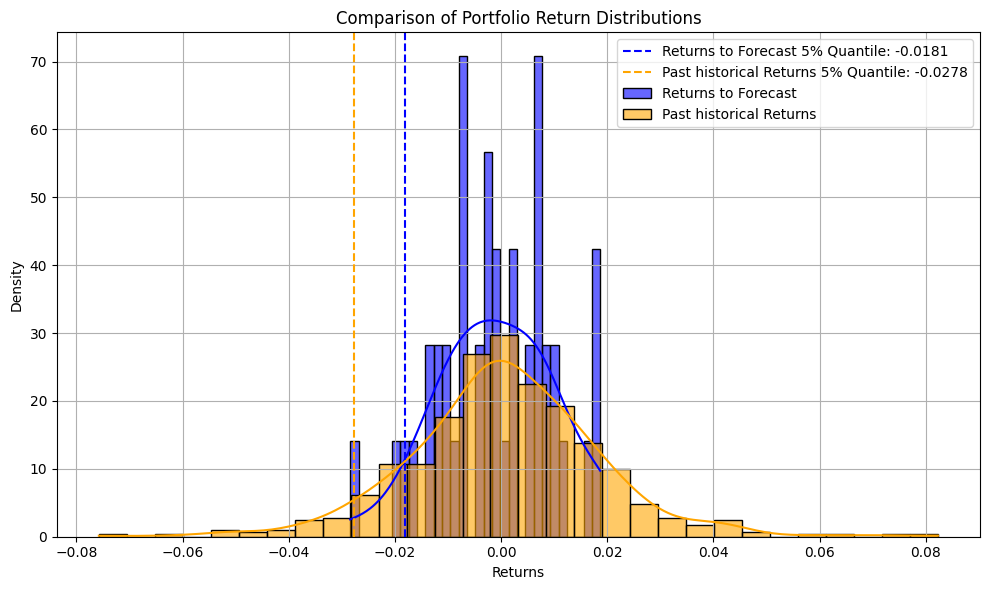

In [170]:
index = 2

compare_portfolio_distributions(returns[2]['portofolio'],portofolios[index].returns['portofolio'])

In [171]:
values_at_risk = []
for portofolio in portofolios:
    try:
        var = VaR(portofolio, confidence_level=0.95)

        values_at_risk.append(
            {
                "historical": -var.calculate_historical_var()['relative'],
                "parametric": -var.calculate_parametric_var()['relative'],
                "monte_carlo": -var.calculate_monte_carlo_var()['relative'],
            }
        )
    except:
        print('VaR could not be calculated')

In [172]:


def show_portfolio_distribution_with_vars(returns, var_dict, time_horizon=1, quantile=0.05, ):
    # Plot the distribution with histogram and KDE
    returns = returns * np.sqrt(time_horizon)  # Scale returns for the time horizon
    sns.histplot(returns, bins=50, kde=True)
    
    # Plot the base quantile (for reference)
    base_quantile = returns.quantile(quantile)
    plt.axvline(base_quantile, color='black', 
                label=f'{quantile*100:.0f}% Quantile of Returns: {base_quantile:.4f}')
    
    # Define a unique color for each VaR method
    colors = {
        "historical": "red",
        "parametric": "blue",
        "monte_carlo": "green"
    }
    
    # Plot a vertical line for each VaR method
    for method, var_value in var_dict.items():
        plt.axvline(var_value, color=colors.get(method, "gray"), linestyle='dashed', 
                    label=f'{method.capitalize()} VaR: {var_value:.4f}')
    
    # Determine the range to zoom in on the vertical lines
    # Get minimum and maximum of base quantile and all VaR values
    values = [base_quantile] + list(var_dict.values())
    min_val, max_val = min(values), max(values)
    
    # Calculate margin: you can adjust this multiplier to zoom in/out as desired
    margin = (max_val - min_val) * 0.5  
    plt.xlim(min_val - margin, max_val + margin)
    
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.title('Portfolio Return Distribution with VaR Estimates')
    plt.legend()
    plt.show()



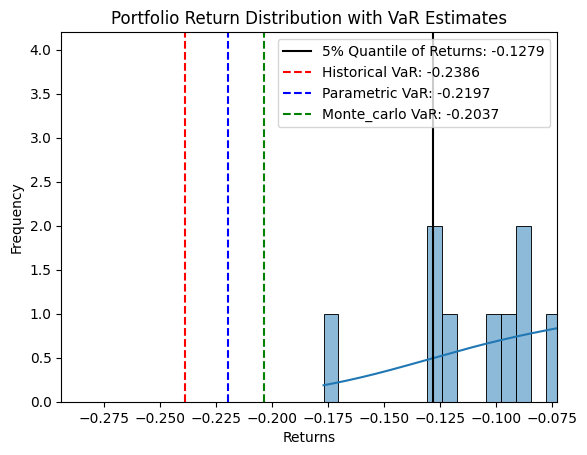

In [173]:
min_index = 4
show_portfolio_distribution_with_vars(returns[min_index]['portofolio'][:], values_at_risk[min_index], time_horizon=portofolios[min_index].Time, quantile=0.05)

##### RMSE

For our chosen way of comparing the models, we will pick the root mean square error (RMSE).

In [174]:
def root_mean_squared_error(prediction, truth):
    return np.sqrt(np.mean((prediction - truth) ** 2))

In [252]:
worst_losses = []
values_at_risk = {
    0.99:[],
    0.95:[],
    0.90:[],
    0.85:[],
    0.8:[],
    0.75:[],
    0.7:[],

}

for portofolio in portofolios[:]:
    forecast_start_date = portofolio.forecast_start_date
    returns_array, _, _ = portofolio.get_data(start_date=forecast_start_date - dt.timedelta(days=1),
                                               end_date=forecast_start_date + dt.timedelta(days=(portofolio.Time + 1)),
                                               yahoo_finance=False)

    returns_array = returns_array['portofolio']
    # print(returns_array)

    # 1. Start with an initial value of +0% (Day 0)
    cumulative_returns = (1 + returns_array).cumprod() - 1

    # 2. Calculate the maximum cumulative return up to each point in time
    max_cumulative_returns = cumulative_returns.cummax()

    # 3. Calculate the drawdown (difference from the peak at each point in time)
    drawdowns = cumulative_returns - max_cumulative_returns

    # 4. Find the worst loss (maximum drawdown)
    worst_loss = drawdowns.min()
    worst_losses.append(worst_loss)
    for conf_level in values_at_risk.keys():
        var_obj = VaR(portofolio, confidence_level=conf_level)
        values_at_risk[conf_level].append(var_obj.calculate_all_vars('relative',-1))




0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.95
0.9
0.85
0.8
0.75
0.7
0.99
0.9

In [176]:
for conf_level in values_at_risk.keys():
    new_dict = {
        'historical':[],
        'parametric':[],
        'monte_carlo':[],
    }
    for element in values_at_risk[conf_level]:
        for method in element.keys():
            new_dict[method].append(element[method])
    values_at_risk[conf_level] = new_dict

In [177]:
flattened_dict = {}

for confidence_level, methods in values_at_risk.items():
    for method, values in methods.items():
        key = f"{confidence_level}_{method}"  # Create new key like '90_historical'
        flattened_dict[key] = values

values_at_risk = flattened_dict

In [178]:
rmse_dict = {}

for key, predictions in flattened_dict.items():
    # Extract the confidence level from the key to match with the worst_losses (assuming they are aligned)
    rmse_dict[key] = root_mean_squared_error(np.array(predictions), np.array(worst_losses))

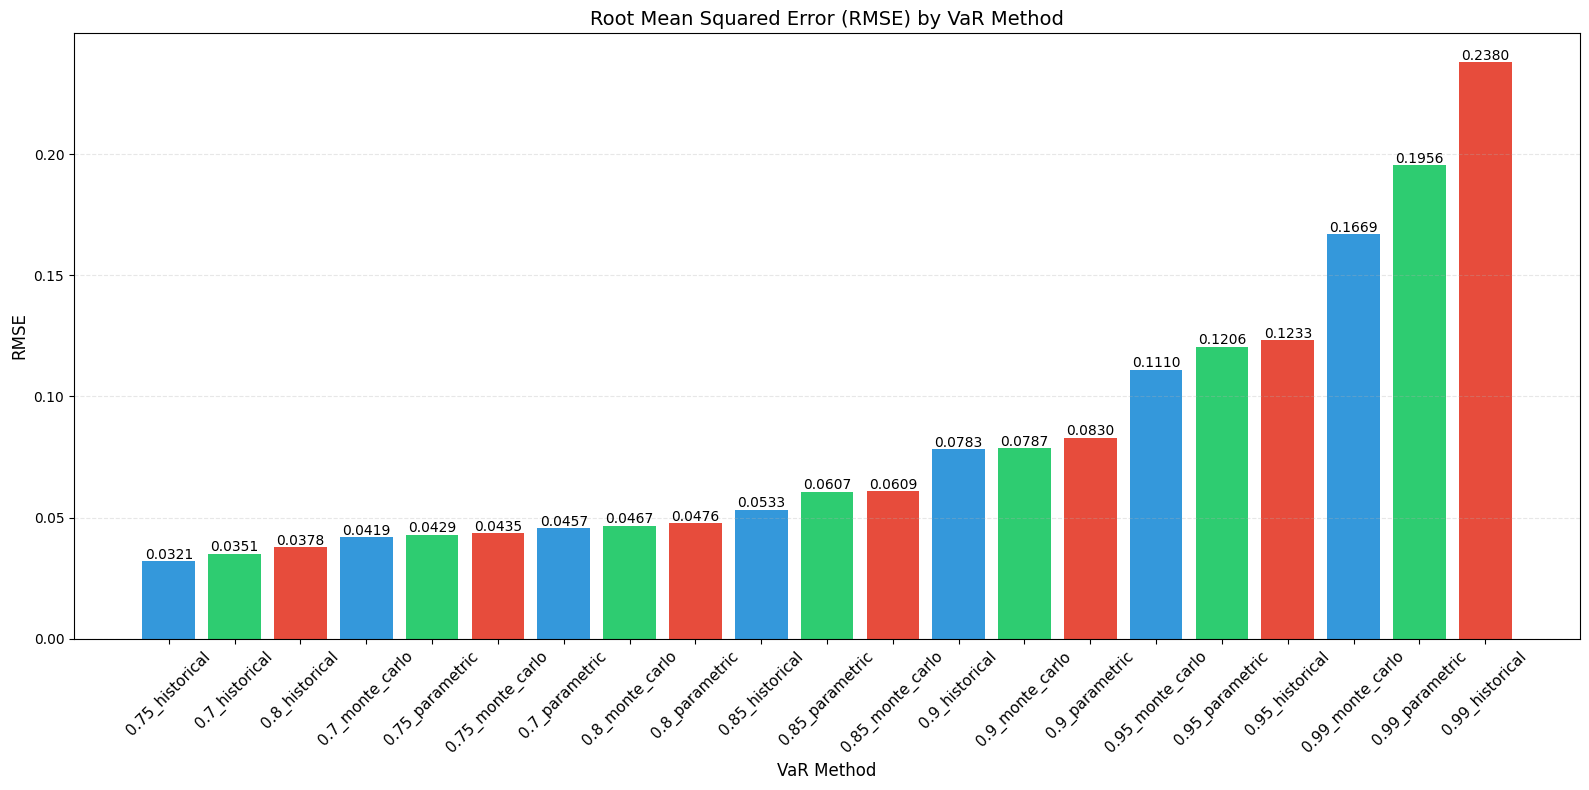

In [179]:
# Sort rmse_dict by RMSE values in ascending order
sorted_rmse_dict = dict(sorted(rmse_dict.items(), key=lambda item: item[1]))

# Extract values and labels from sorted_rmse_dict
methods = list(sorted_rmse_dict.keys())
rmse_values = list(sorted_rmse_dict.values())

# Create bar chart
plt.figure(figsize=(16, 8))
bars = plt.bar(methods, rmse_values, color=['#3498db', '#2ecc71', '#e74c3c'] * (len(methods) // 3 + 1))

# Add value labels on top of each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{rmse_values[i]:.4f}', ha='center', fontsize=10)

# Add title and labels
plt.title('Root Mean Squared Error (RMSE) by VaR Method', fontsize=14)
plt.ylabel('RMSE', fontsize=12)
plt.xlabel('VaR Method', fontsize=12)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Rotate x-axis labels
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.show()


##### Backtesting

In [220]:
from copy import deepcopy

In [258]:
def backtest_portofolio(portofolio, conf_level=0.95,start_date = dt.datetime.strptime("2018-10-01", "%Y-%m-%d"), days=1000, ):
    columns = ['historical', 'parametric', 'monte_carlo', 'actual']
    backtesting_returns = pd.DataFrame(columns=columns)
    backtesting_returns.index.name = 'Date'
    test_portofolio_template = deepcopy(portofolio)

    
    for i in range(0,days):
        forecast_start_date = date_start + dt.timedelta(days=i)
        test_portofolio = PortofolioData(
            stocks=test_portofolio_template.stocks,
            weights=test_portofolio_template.weights,
            Time=1,
            initial_investment=test_portofolio_template.initial_investment,
            forecast_start_date=  forecast_start_date,
            yahoo_finance=False,
        )
        try:
            ret, _, _ = test_portofolio.get_data(
                forecast_start_date - dt.timedelta(days=10),
                forecast_start_date + dt.timedelta(days=10),
            )
            _ = ret['portofolio'].loc[forecast_start_date]

            actual = ret['portofolio'].loc[forecast_start_date]

            var_obj = VaR(test_portofolio, confidence_level=conf_level)
            rez = var_obj.calculate_all_vars('relative',-1)
            rez['actual'] = actual
            backtesting_returns.loc[forecast_start_date] = rez
        except Exception as e:
            continue

    return backtesting_returns

In [230]:
def get_breaches_count(backtesting_returns):
    historical_breaches = (backtesting_returns['actual'] < backtesting_returns['historical']).sum()
    parametric_breaches = (backtesting_returns['actual'] < backtesting_returns['parametric']).sum()
    monte_carlo_breaches = (backtesting_returns['actual'] < backtesting_returns['monte_carlo']).sum()

    return {
        'historical': historical_breaches,
        'parametric': parametric_breaches,
        'monte_carlo': monte_carlo_breaches,
    }
def get_breaches_percentage(backtesting_returns):
    historical_breaches = (backtesting_returns['actual'] < backtesting_returns['historical']).sum()
    parametric_breaches = (backtesting_returns['actual'] < backtesting_returns['parametric']).sum()
    monte_carlo_breaches = (backtesting_returns['actual'] < backtesting_returns['monte_carlo']).sum()

    total_days = len(backtesting_returns)

    return {
        'historical': (historical_breaches / total_days) * 100,
        'parametric': (parametric_breaches / total_days) * 100,
        'monte_carlo': (monte_carlo_breaches / total_days) * 100,
    }

def print_breaches_count(breaches_count):
    print("Breaches Count:")
    for method, count in breaches_count.items():
        print(f"{method.capitalize()}: {count}")

def print_breaches_percentage(breaches_percentage):
    print("\nBreaches Percentage:")
    for method, percentage in breaches_percentage.items():
        print(f"{method.capitalize()}: {percentage:.2f}%")



In [266]:
backtest_1_95_df = backtest_portofolio(portofolios[1],conf_level=0.95,days=1000)
backtest_1_99_df = backtest_portofolio(portofolios[1],conf_level=0.99, days=1000)


In [267]:
print("Backtest - Portofolio 1 (95% confidence level):")
print('Expected breach %: 5%')
print_breaches_percentage(get_breaches_percentage(backtest_1_95_df))
print('\n')
print("Backtest - Portofolio 1 (99% confidence level):")
print('Expected breach %: 1%')
print_breaches_percentage(get_breaches_percentage(backtest_1_99_df))

Backtest - Portofolio 1 (95% confidence level):
Expected breach %: 5%

Breaches Percentage:
Historical: 6.82%
Parametric: 6.39%
Monte_carlo: 6.53%


Backtest - Portofolio 1 (99% confidence level):
Expected breach %: 1%

Breaches Percentage:
Historical: 2.03%
Parametric: 3.19%
Monte_carlo: 3.19%


### Custom VaR Model

#### We will try a ARIMA model based on the returns

In [181]:
from statsmodels.tsa.arima.model import ARIMA

In [182]:
import warnings
warnings.filterwarnings("ignore")

In [183]:

def forecast_portfolio(portofolio, training_days=300, plot=True):
    # Prepare the training data
    training_data = portofolio.returns['portofolio'].loc[
    portofolio.forecast_start_date - dt.timedelta(days=training_days) : portofolio.forecast_start_date - dt.timedelta(days=1)
]

    print(training_data.shape)

    p, d, q = 1, 0, 1  

    # Fit the ARIMA model
    model = ARIMA(training_data, order=(p, d, q))
    model_fit = model.fit()

    # Forecast future returns
    forecast = model_fit.forecast(steps=portofolio.Time)
    
    # Build forecast dates
    forecast_dates = pd.date_range(start=portofolio.forecast_start_date, periods=portofolio.Time, freq='B')
    forecast_series = pd.Series(forecast.values, index=forecast_dates)
    # Get actual data
    actual_data, _, _ = portofolio.get_data(
        start_date=portofolio.forecast_start_date - dt.timedelta(days=1),
        end_date=portofolio.forecast_start_date + dt.timedelta(days=portofolio.Time),
        yahoo_finance=False
    )
    actual_data = actual_data['portofolio']

    # Plot
    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(forecast_series, label='Forecasted Returns', color='blue')
        plt.plot(actual_data.index, actual_data.values, label='Actual Returns', color='red')
        plt.title('Forecasted vs Actual Portfolio Returns')
        plt.xlabel('Date')
        plt.ylabel('Returns')
        plt.legend()
        plt.grid(True)
        plt.show()

    return forecast_series


(204,)


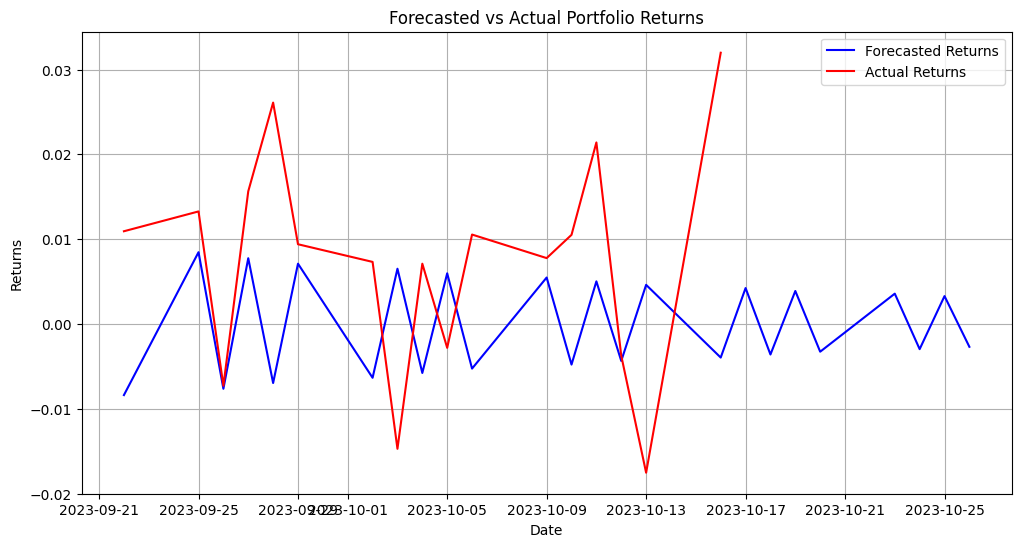

2023-09-22   -0.008388
2023-09-25    0.008460
2023-09-26   -0.007646
2023-09-27    0.007750
2023-09-28   -0.006968
2023-09-29    0.007102
2023-10-02   -0.006348
2023-10-03    0.006510
2023-10-04   -0.005782
2023-10-05    0.005969
2023-10-06   -0.005265
2023-10-09    0.005474
2023-10-10   -0.004792
2023-10-11    0.005022
2023-10-12   -0.004360
2023-10-13    0.004609
2023-10-16   -0.003965
2023-10-17    0.004231
2023-10-18   -0.003604
2023-10-19    0.003886
2023-10-20   -0.003274
2023-10-23    0.003571
2023-10-24   -0.002973
2023-10-25    0.003283
2023-10-26   -0.002697
Freq: B, dtype: float64

In [184]:
forecast_portfolio(portofolios[1])

(20,)


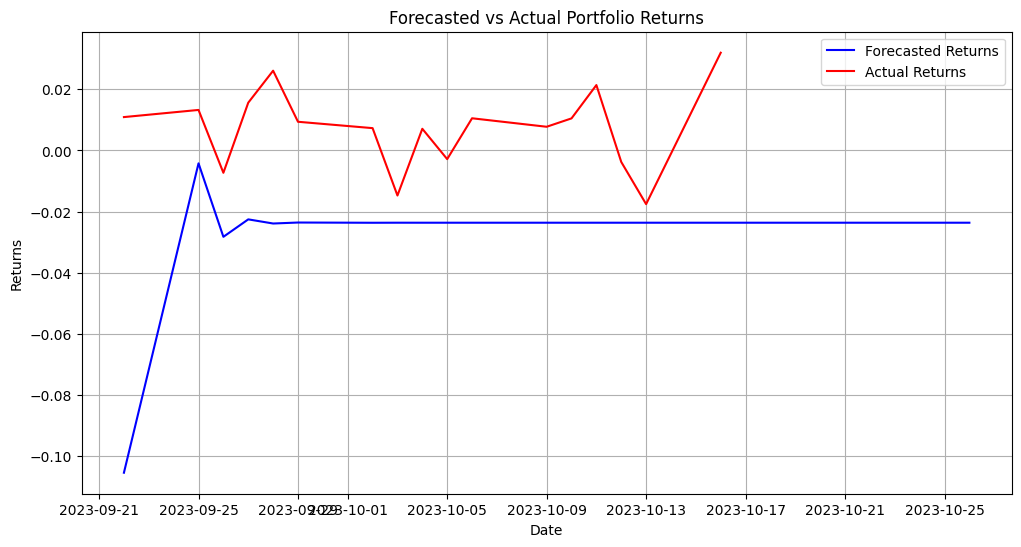

2023-09-22   -0.105384
2023-09-25   -0.004199
2023-09-26   -0.028231
2023-09-27   -0.022523
2023-09-28   -0.023879
2023-09-29   -0.023557
2023-10-02   -0.023633
2023-10-03   -0.023615
2023-10-04   -0.023620
2023-10-05   -0.023619
2023-10-06   -0.023619
2023-10-09   -0.023619
2023-10-10   -0.023619
2023-10-11   -0.023619
2023-10-12   -0.023619
2023-10-13   -0.023619
2023-10-16   -0.023619
2023-10-17   -0.023619
2023-10-18   -0.023619
2023-10-19   -0.023619
2023-10-20   -0.023619
2023-10-23   -0.023619
2023-10-24   -0.023619
2023-10-25   -0.023619
2023-10-26   -0.023619
Freq: B, dtype: float64

In [185]:
forecast_portfolio(portofolios[1], training_days=30)

(7,)


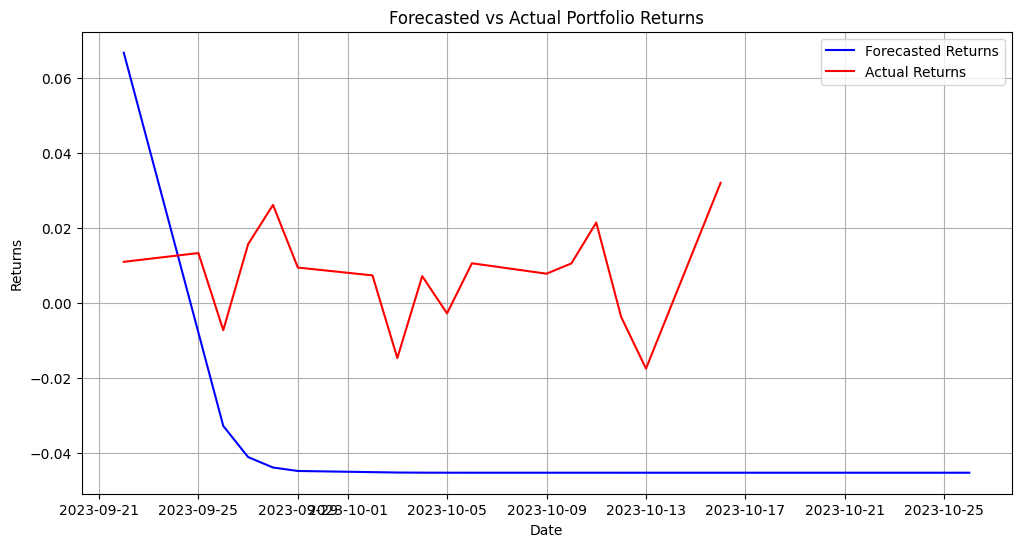

2023-09-22    0.066672
2023-09-25   -0.007922
2023-09-26   -0.032819
2023-09-27   -0.041129
2023-09-28   -0.043903
2023-09-29   -0.044829
2023-10-02   -0.045138
2023-10-03   -0.045241
2023-10-04   -0.045275
2023-10-05   -0.045287
2023-10-06   -0.045291
2023-10-09   -0.045292
2023-10-10   -0.045292
2023-10-11   -0.045292
2023-10-12   -0.045292
2023-10-13   -0.045292
2023-10-16   -0.045292
2023-10-17   -0.045292
2023-10-18   -0.045292
2023-10-19   -0.045292
2023-10-20   -0.045292
2023-10-23   -0.045292
2023-10-24   -0.045292
2023-10-25   -0.045292
2023-10-26   -0.045292
Freq: B, dtype: float64

In [186]:
forecast_portfolio(portofolios[1], training_days=10)

We can see that it is impossible to accurately forecast a portofolio's returns with ARIMA. It finds it difficult to predict the future returns and simply forecasts the average.

(8,)


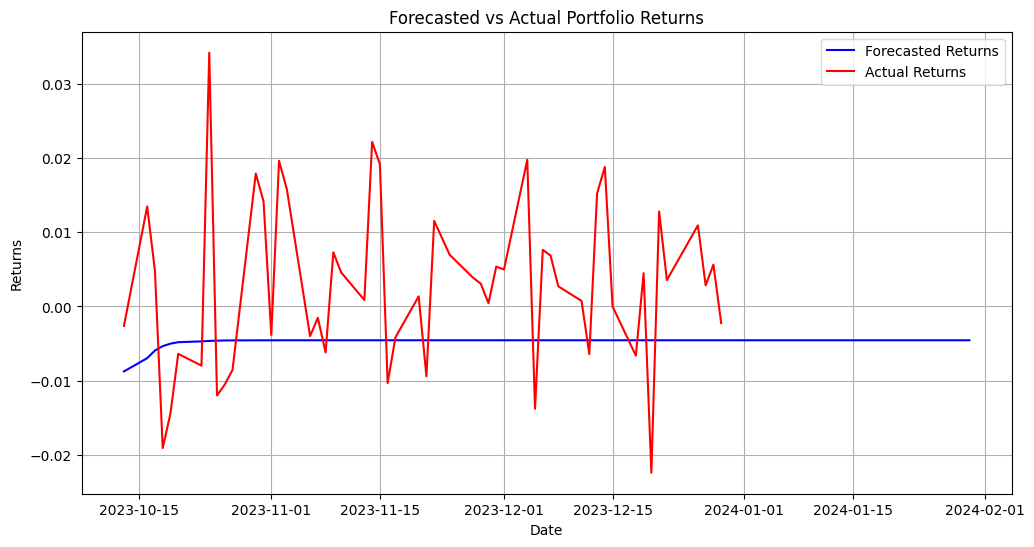

2023-10-13   -0.008752
2023-10-16   -0.006962
2023-10-17   -0.005935
2023-10-18   -0.005346
2023-10-19   -0.005009
                ...   
2024-01-24   -0.004554
2024-01-25   -0.004554
2024-01-26   -0.004554
2024-01-29   -0.004554
2024-01-30   -0.004554
Freq: B, Length: 78, dtype: float64

In [187]:
forecast_portfolio(portofolios[0], training_days=10)

It forecasts a bit "braver" returns only when provided with a small training data pool and a small time horizon.

Therefore, ARIMA is not a good model to try to predict losses, as it is being too "safe".

In [188]:
arimas = []
arima_returns = []
for portofolio in portofolios[:]:
  
    arima_rez = forecast_portfolio(portofolio, plot=False)
    arima_returns.append(arima_rez)
    cum_returns_arima = (1 + arima_rez).cumprod() - 1
    max_cumulative_returns_arima = cum_returns_arima.cummax()
    drawdowns_arima = cum_returns_arima - max_cumulative_returns_arima
    worst_loss_arima = drawdowns_arima.min()
    arimas.append(worst_loss_arima)


(204,)
(204,)
(206,)
(206,)
(204,)
(205,)
(206,)
(206,)
(206,)
(206,)
(205,)
(204,)
(204,)
(204,)
(207,)
(204,)
(205,)
(205,)
(206,)
(205,)
(205,)
(206,)
(208,)
(204,)
(206,)
(208,)
(204,)
(207,)
(206,)
(206,)
(204,)
(205,)
(207,)
(206,)
(205,)
(205,)
(205,)
(206,)
(205,)
(205,)
(207,)
(204,)
(206,)
(205,)
(207,)
(206,)
(204,)
(205,)
(206,)
(205,)
(207,)
(207,)
(206,)
(205,)
(205,)
(205,)
(208,)
(204,)
(205,)
(205,)
(209,)
(208,)
(204,)
(206,)
(207,)
(206,)
(207,)
(204,)
(207,)
(204,)
(205,)
(208,)
(205,)
(205,)
(205,)
(205,)
(206,)
(205,)
(207,)
(205,)
(205,)
(206,)
(205,)
(206,)
(205,)
(205,)
(203,)
(205,)
(207,)
(205,)
(205,)
(204,)
(204,)
(205,)
(204,)
(208,)
(204,)
(205,)
(207,)
(205,)


In [189]:
arimas

[-0.09266430628846611,
 -0.007645950607744312,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.0009645141562324433,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -5.818591218942348e-05,
 0.0,
 0.0,
 0.0,
 -0.043900533888750704,
 0.0,
 0.0,
 -0.004582698911397065,
 0.0,
 0.0,
 -0.018460388768076874,
 0.0,
 -0.08753416606914532,
 0.0,
 0.0,
 0.0,
 -0.012102435443767434,
 -0.01979339710884076,
 0.0,
 -0.00011910701182604733,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.00016468739943631405,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.0004306216347498282,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -9.399327179693273e-05,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.01030066380059469,
 0.0,
 -0.001404274679575046,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.030159436180129617]

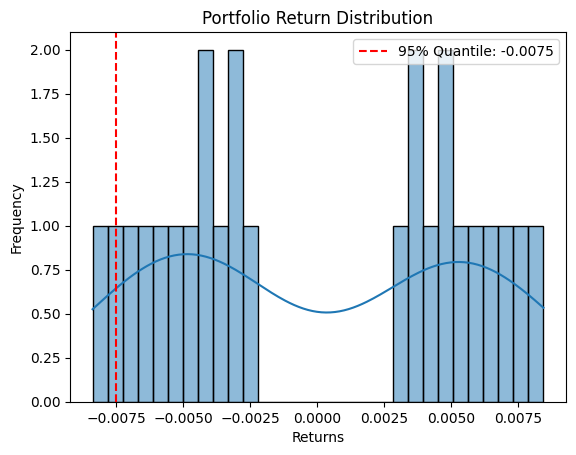

In [190]:
show_portfolio_distribution(arima_returns[1])

In [191]:
rmse_dict['arima'] = root_mean_squared_error(np.array(arimas), np.array(worst_losses))

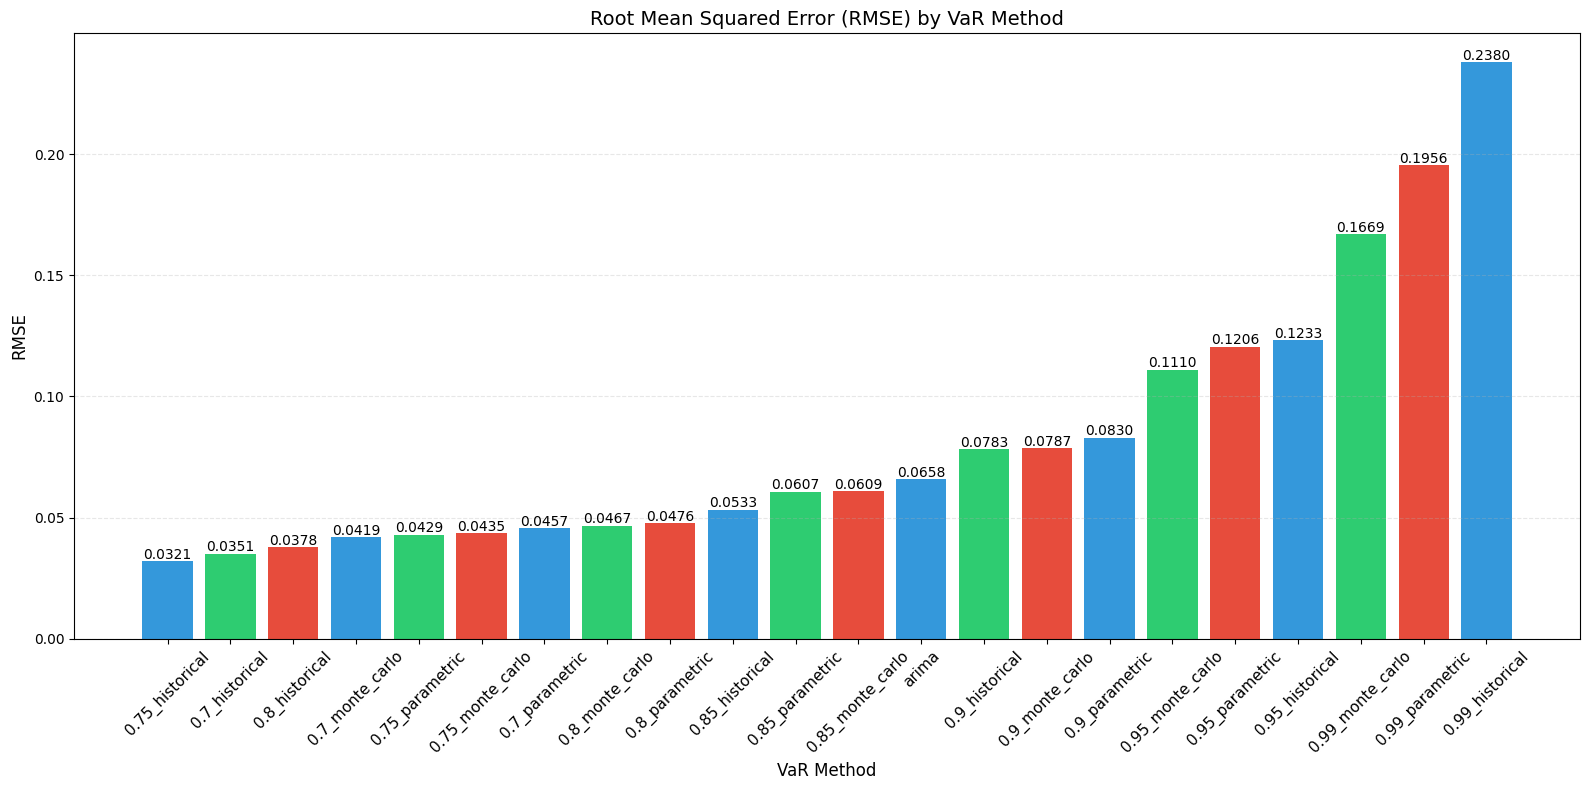

In [192]:
# Sort rmse_dict by RMSE values in ascending order
sorted_rmse_dict = dict(sorted(rmse_dict.items(), key=lambda item: item[1]))

# Extract values and labels from sorted_rmse_dict
methods = list(sorted_rmse_dict.keys())
rmse_values = list(sorted_rmse_dict.values())

# Create bar chart
plt.figure(figsize=(16, 8))
bars = plt.bar(methods, rmse_values, color=['#3498db', '#2ecc71', '#e74c3c'] * (len(methods) // 3 + 1))

# Add value labels on top of each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{rmse_values[i]:.4f}', ha='center', fontsize=10)

# Add title and labels
plt.title('Root Mean Squared Error (RMSE) by VaR Method', fontsize=14)
plt.ylabel('RMSE', fontsize=12)
plt.xlabel('VaR Method', fontsize=12)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Rotate x-axis labels
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.show()


We can see that the RMSE of our arima model is smaller than the 95% and 99% VaRs. This is because high confidence-level VaRs tend to overestimate the risk. However, since ARIMA tends to UNDERestimate risk, it falls behind the other VaRs, that are overall more well rounded. 